In [1]:
# Импорт библиотек
import os
import time
import cotel
import GTU
import mat_properties as prop
import numpy as n
import pandas as pd
from scipy.optimize import root

# Основные константы
calctolerance = 10**-3
calcmethod = "hybr"
KPDnasos = 0.8074
KPD = 0.99

# таблица номинального режима
gas_streams0 = pd.read_excel("streams0.xlsx", sheet_name="gas", index_col=0)
water_streams0 = pd.read_excel(
    "streams0.xlsx", sheet_name="water", index_col=0)
GTU_ISO = pd.read_excel("input.xlsx", sheet_name="ISO", index_col=0)
GTU_input = pd.read_excel("input.xlsx", sheet_name="GTU_input", index_col=0)
# рабочая таблица (=номинал в 1 итерации)
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
water_streams = pd.read_excel("streams.xlsx", sheet_name="water", index_col=0)
# рабочая таблица показателей блоков
heaters = pd.read_excel("blocks.xlsx", sheet_name="heaters", index_col=0)
electric = pd.read_excel("blocks.xlsx", sheet_name="electric", index_col=0)


# Состав газов в номинале
gasmix = "Nitrogen*Oxygen*CO2*Water*Argon"
# Считывание рефпропа
RP = prop.init_REFPROP(r"C:\Program Files (x86)\REFPROP")
fractiongas0 = (
    gas_streams0.at["GTU-PEVD", "N2"],
    gas_streams0.at["GTU-PEVD", "O2"],
    gas_streams0.at["GTU-PEVD", "CO2"],
    gas_streams0.at["GTU-PEVD", "H2O"],
    gas_streams0.at["GTU-PEVD", "Ar"],
)

gas0 = prop.Materials_prop(
    gasmix,
    fractiongas0,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    RP=RP,
)
water = prop.Materials_prop(
    "water",
    [1.0, 0, 0, 0, 0],
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    RP=RP,
)


# Задание энтальпий газа в номинальном режиме
Temperatures = gas_streams0.loc["GTU-KU":"GPK-out", "T"]
Pressure= gas_streams0.loc["GTU-KU", "P"]
Enthalpies = list(map(lambda x: gas0.p_t(Pressure, x)["h"], Temperatures))
gas_streams0.loc["GTU-KU":"GPK-out", "H"] = Enthalpies


####################################################################################################
# Расчет ГТУ
Gas_turbine = GTU.gtu(GTU_ISO, GTU_input, "GTU-KU")
Gas_turbine_res = Gas_turbine.calc()
electric.loc["GTU", "N"] = Gas_turbine_res["N"]
electric.loc["GTU", "KPD"] = Gas_turbine_res["eff"]
electric.loc["DK", "N"] = Gas_turbine_res["Ndk"]
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
gas_streams.loc["GTU-KU", "T"] = Gas_turbine_res["T"]
gas_streams.loc["GTU-KU", "G"] = Gas_turbine_res["G"]
gas_streams.loc["GTU-KU", "P"] = 0.1
Gas_turbine_composition=pd.read_excel("input.xlsx", sheet_name="Gas_composition0", index_col=0)


#Параметры газа на выходе в КУ
gas_streams.loc["GTU-PEVD", "T":"P"] = gas_streams.loc["GTU-KU", "T":"P"]
gas_streams.loc["GTU-PEVD", "G"] = gas_streams.loc["GTU-KU", "G"]
gas_streams.loc["GTU-PEVD", "N2":"Ar"]=Gas_turbine_composition.loc["Fraction", "N2":"Ar"]

# Состав газов при частичной нагрузке
fractiongas = (
    gas_streams.at["GTU-PEVD", "N2"],
    gas_streams.at["GTU-PEVD", "O2"],
    gas_streams.at["GTU-PEVD", "CO2"],
    gas_streams.at["GTU-PEVD", "H2O"],
    gas_streams.at["GTU-PEVD", "Ar"],
)
gas1 = prop.Materials_prop(
    gasmix,
    fractiongas,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    RP=RP,
)

# # Задание энтальпий газа в рабочем режиме
# Temperatures = gas_streams.loc["GTU-KU":"GPK-out", "T"]
# Pressure= gas_streams.loc["GTU-KU", "P"]
# Enthalpies = list(map(lambda x: gas1.p_t(Pressure, x)["h"], Temperatures))
# gas_streams.loc["GTU-KU":"GPK-out", "H"] = Enthalpies

####################################################################################################
# расчет котла целиком
Whole_cotel = cotel.cotel_all(
    KPD,
    KPDnasos,
    gas0,
    gas1,
    water,
    calcmethod,
    gas_streams0,
    water_streams0,
    gas_streams,
    water_streams,
    heaters,
    electric
)
Whole_cotel.calc(calctolerance*100,maxiterations=10)


Whole_cotel = cotel.cotel_all(
    KPD,
    KPDnasos,
    gas0,
    gas1,
    water,
    calcmethod,
    gas_streams0,
    water_streams0,
    gas_streams,
    water_streams,
    heaters,
    electric
)
Whole_cotel.calc(calctolerance*10,maxiterations=10)


print(
    "Степень сухости пара в ЭВД: ",
    water.p_h(water_streams.at["EVD-IVD", "P"],
              water_streams.at["EVD-IVD", "H"])["Q"],
)
print(
    "Степень сухости пара в ГПК: ",
    water.p_h(water_streams.at["GPK-IND", "P"],
              water_streams.at["GPK-IND", "H"])["Q"],
)

Достигнуто максимальное количество итераций контура ГПК
dQ/Qsumm 2.361512287426756
dQ/Qsumm -0.019570194545250084
Fin:--- 21.33 сек. ---
dQ/Qsumm -0.019570194545250084
dQ/Qvd -0.05137386771956573
dQ/Qnd 0.005629819292010887
Достигнуто максимальное количество итераций контура высокого давления
dQ/Qsumm -0.3323983709562117
Достигнуто максимальное количество итераций контура высокого давления
dQ/Qsumm -0.012332725246387793
dQ/Qsumm 0.001546046661710997
Fin:--- 43.14 сек. ---
dQ/Qsumm 0.001546046661710997
dQ/Qvd -0.0016652436229944961
dQ/Qnd 0.006898045000094483
Степень сухости пара в ЭВД:  0.0069787680082348666
Степень сухости пара в ГПК:  -9999990.0


In [2]:
# Вывод газовых потоков
gas_streams

,T,P,H,G,N2,O2,CO2,H2O,Ar
AIR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTU-KU,509.892416,0.1,958.869199,354.05446,0.7803,0.1237,0.0301,0.0594,0.0065
GTU-PEVD,509.892416,0.1,921.662785,354.05446,0.7803,0.1237,0.0301,0.0594,0.0065
PEVD-IVD,447.450818,0.1,850.752704,354.05446,0.7803,0.1237,0.0301,0.0594,0.0065
IVD-EVD,304.613976,0.1,692.415610,354.05446,0.7803,0.1237,0.0301,0.0594,0.0065
EVD-PPND,246.901214,0.1,629.906564,354.05446,0.7803,0.1237,0.0301,0.0594,0.0065
PPND-IND,243.504105,0.1,626.251347,354.05446,0.7803,0.1237,0.0301,0.0594,0.0065
IND-GPK,174.620202,0.1,552.660549,354.05446,0.7803,0.1237,0.0301,0.0594,0.0065
GPK-out,103.059074,0.1,477.120315,354.05446,0.7803,0.1237,0.0301,0.0594,0.0065


In [3]:
# Вывод водяных потоков
water_streams

,T,P,H,G,S,X
AIR,NaN,NaN,NaN,NaN,NaN,NaN
PEVD-DROSVD,492.555196,8.407000,3375.957095,39.717696,NaN,NaN
IVD-PEVD,299.635042,8.543836,2750.337634,39.717696,NaN,NaN
EVD-IVD,299.635042,8.543836,1352.786814,39.717696,NaN,NaN
PEN-EVD,187.800240,8.543836,801.137567,39.717696,NaN,NaN
BND-PEN,164.647503,0.694831,695.699440,39.717696,NaN,NaN
PPND-DROSND,208.935132,0.691000,2865.608010,12.423564,NaN,NaN
IND-PPND,164.647502,0.694831,2762.439597,12.423564,NaN,NaN
GPK-IND,164.130202,0.694831,693.449677,52.141261,NaN,NaN
GPK-REC,164.130202,0.694831,693.449677,59.945092,NaN,NaN


In [4]:
water_streams0['PEVD-DROSVD':'REC-GPK']

,T,P,H,G,S,Unnamed: 6,Unnamed: 7
PEVD-DROSVD,511.500000,8.4070,3423.209978,63.40,NaN,NaN,NaN
IVD-PEVD,301.297556,8.7460,2747.104023,63.40,NaN,NaN,NaN
EVD-IVD,298.800000,8.7460,1337.948265,63.40,NaN,NaN,NaN
PEN-EVD,166.500000,8.7460,708.319849,63.40,NaN,NaN,NaN
BND-PEN,164.738361,0.6964,696.095567,63.40,NaN,NaN,NaN
PPND-DROSND,211.600000,0.6910,2871.481837,14.76,NaN,NaN,NaN
IND-PPND,164.738361,0.6964,2762.534980,14.76,NaN,NaN,NaN
GPK-IND,164.600000,0.6964,695.493701,78.16,NaN,NaN,NaN
GPK-REC,164.600000,0.6964,695.493701,82.91,NaN,NaN,NaN
REC-GPK,60.000000,0.6964,251.748396,82.91,NaN,NaN,NaN


In [5]:
Errors_water= abs(water_streams.loc['PEVD-DROSVD':'REC-GPK','T':'G'] -water_streams0.loc['PEVD-DROSVD':'REC-GPK','T':'G'])/water_streams0.loc['PEVD-DROSVD':'REC-GPK','T':'G']*100
Errors_water

,T,P,H,G
PEVD-DROSVD,3.703774,0.000000,1.380368,37.353791
IVD-PEVD,0.551785,2.311498,0.117710,37.353791
EVD-IVD,0.279465,2.311498,1.109053,37.353791
PEN-EVD,12.792937,2.311498,13.103927,37.353791
BND-PEN,0.055153,0.225327,0.056907,37.353791
PPND-DROSND,1.259389,0.000000,0.204557,15.829511
IND-PPND,0.055154,0.225327,0.003453,15.829511
GPK-IND,0.285418,0.225327,0.293895,33.289073
GPK-REC,0.285418,0.225327,0.293895,27.698598
REC-GPK,0.000000,0.225327,0.000523,27.707322


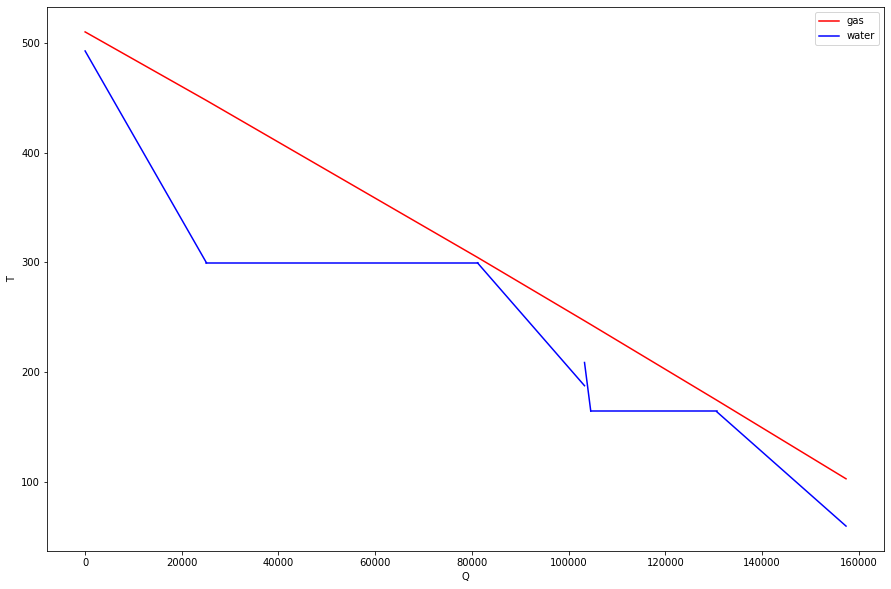

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
Qg =[0,
    heaters.loc['PEVD','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg']+heaters.loc['PPND','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg']+heaters.loc['PPND','Qg']+heaters.loc['IND','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg']+heaters.loc['PPND','Qg']+heaters.loc['IND','Qg']+heaters.loc['GPK','Qg']
    ]
Qw =[0,
    heaters.loc['PEVD','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg']+heaters.loc['PPND','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg']+heaters.loc['PPND','Qg']+heaters.loc['IND','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg']+heaters.loc['PPND','Qg']+heaters.loc['IND','Qg'],
    heaters.loc['PEVD','Qg']+heaters.loc['IVD','Qg']+heaters.loc['EVD','Qg']+heaters.loc['PPND','Qg']+heaters.loc['IND','Qg']+heaters.loc['GPK','Qg']
    ]
Tg = gas_streams.loc['GTU-PEVD':'GPK-out','T']
Tw = [water_streams.loc['PEVD-DROSVD','T'],
      water_streams.loc['IVD-PEVD','T'],
      water_streams.loc['IVD-PEVD','T'],
      water_streams.loc['EVD-IVD','T'],
      water_streams.loc['PEN-EVD','T'],
      water_streams.loc['PPND-DROSND','T'],
      water_streams.loc['IND-PPND','T'],
      water_streams.loc['IND-PPND','T'],
      water_streams.loc['GPK-REC','T'],
      water_streams.loc['REC-GPK','T'],
     ]
plt.plot(Qg,Tg, color = 'red')
plt.plot(Qw[0:2],Tw[0:2], color = 'blue')
plt.plot(Qw[1:3],Tw[1:3], color = 'blue')
plt.plot(Qw[3:5],Tw[3:5], color = 'blue')
plt.plot(Qw[5:7],Tw[5:7], color = 'blue')
plt.plot(Qw[6:8],Tw[6:8], color = 'blue')
plt.plot(Qw[8:10],Tw[8:10], color = 'blue')
plt.xlabel('Q')
plt.ylabel('T')
plt.legend(['gas','water'])
plt.show()